In [1]:
import numpy as np
from pandas import read_csv
import pandas_datareader.data as web
import matplotlib.pyplot as plt


In [2]:
lstm_data = read_csv('lstmona.csv')
lstm_data = lstm_data.drop(['Date'], axis=1)
print(lstm_data)

        High       Low      Open     Close   Volume  Adj Close  Polarity Score
0   1.241455  1.182781  1.236694  1.184539  1251855   1.184539        0.095867
1   1.054188  1.000561  1.016678  1.008785   467346   1.008785        0.146020
2   1.022445  0.989817  1.014940  0.996675   304333   0.996675        0.138143
3   0.978820  0.965322  0.970673  0.972663   205397   0.972663        0.146417
4   0.815332  0.799816  0.809788  0.803426   128781   0.803426        0.134860
..       ...       ...       ...       ...      ...        ...             ...
63  1.020251  0.994093  1.002975  0.999426   565050   0.999426        0.114973
64  0.851174  0.818889  0.843720  0.824758   153179   0.824758        0.131016
65  1.002289  0.977300  0.999467  0.985450   564840   0.985450        0.107061
66  0.833132  0.803969  0.825560  0.804979   208142   0.804979        0.141040
67  1.010521  0.969276  0.985485  0.979062   585842   0.979062        0.083907

[68 rows x 7 columns]


In [3]:
lstm_data_X = lstm_data.drop(['Close'], axis=1)
lstm_data_y = lstm_data['Close']

In [4]:
look_back = 5 # how many days to look back
batch_size = 3 # size of batches used when training
n_feat = 6 # number of features 
n_target = 2
n_validation = 6
n_test = 8
n_train = lstm_data_X.shape[0] - n_validation - n_test - 1


In [5]:
n_train

53

In [6]:
#lstm_data_X_train = lstm_data_X.iloc[:30,:]
#lstm_data_X_val = lstm_data_X.iloc[30:40,:]
#lstm_data_X_test = lstm_data_X.iloc[40:52,:]

#lstm_data_y_train = lstm_data_y.iloc[:30]
#lstm_data_y_val = lstm_data_y.iloc[30:40]
#lstm_data_y_test = lstm_data_y.iloc[40:52]
# Convert to numpy arrays
#X_train = lstm_data_X_train.to_numpy()
#X_val = lstm_data_X_val.to_numpy()
#X_test = lstm_data_X_test.to_numpy()
#y_train = lstm_data_y_train.to_numpy()
#y_val = lstm_data_y_val.to_numpy()
#y_test = lstm_data_y_test.to_numpy()

In [7]:
lstm_data_X_train = lstm_data_X.iloc[:n_train,:]
lstm_data_X_val = lstm_data_X.iloc[n_train:n_train + n_validation,:]
lstm_data_X_test = lstm_data_X.iloc[n_train + n_validation:n_train + n_validation + n_test,:]

lstm_data_y_train = lstm_data_y.iloc[:n_train]
lstm_data_y_val = lstm_data_y.iloc[n_train:n_train + n_validation]
lstm_data_y_test = lstm_data_y.iloc[n_train + n_validation:n_train + n_validation + n_test]
# Convert to numpy arrays
X_train = lstm_data_X_train.to_numpy()
X_val = lstm_data_X_val.to_numpy()
X_test = lstm_data_X_test.to_numpy()
y_train = lstm_data_y_train.to_numpy()
y_val = lstm_data_y_val.to_numpy()
y_test = lstm_data_y_test.to_numpy()

In [8]:
X_test

array([[8.74508977e-01, 8.46216023e-01, 8.54779005e-01, 2.90011000e+05,
        8.53320003e-01, 1.48283467e-01],
       [1.01842594e+00, 9.71315980e-01, 9.74134028e-01, 3.71633000e+05,
        1.01481199e+00, 1.31502325e-01],
       [1.03011203e+00, 9.99375999e-01, 1.00855601e+00, 7.81560000e+05,
        1.00295198e+00, 1.53586280e-01],
       [8.61506999e-01, 8.36389005e-01, 8.52524996e-01, 2.11458000e+05,
        8.43836010e-01, 1.28670540e-01],
       [1.02025104e+00, 9.94093001e-01, 1.00297499e+00, 5.65050000e+05,
        9.99426007e-01, 1.14973180e-01],
       [8.51173997e-01, 8.18889022e-01, 8.43720019e-01, 1.53179000e+05,
        8.24757993e-01, 1.31015680e-01],
       [1.00228906e+00, 9.77299988e-01, 9.99467015e-01, 5.64840000e+05,
        9.85450029e-01, 1.07060620e-01],
       [8.33132029e-01, 8.03969026e-01, 8.25559974e-01, 2.08142000e+05,
        8.04979026e-01, 1.41039940e-01]])

In [9]:
y_test

array([0.85332   , 1.01481199, 1.00295198, 0.84383601, 0.99942601,
       0.82475799, 0.98545003, 0.80497903])

In [10]:
import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, ThresholdedReLU, MaxPooling2D, Embedding, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
# Load the TensorBoard notebook extension.
%load_ext tensorboard
from datetime import datetime


In [11]:
train_data_gen = TimeseriesGenerator(X_train, y_train, length=look_back, batch_size=batch_size)
val_data_gen = TimeseriesGenerator(X_val, y_val, length=look_back, batch_size=batch_size)
test_data_gen = TimeseriesGenerator(X_test, y_test, length=look_back, batch_size=batch_size)

In [12]:
# check generator dimensions
for i in range(len(train_data_gen)):
    x, y = train_data_gen[i]
    print(x.shape, y.shape)

(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)


In [13]:
model_lstm = Sequential()
model_lstm.add(LSTM(32, input_shape=(look_back, n_feat), return_sequences=True))
model_lstm.add(Dropout(0.1))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.1))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer="adam", loss='mse', metrics=["mse"])
print(model_lstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 32)             4992      
                                                                 
 dropout (Dropout)           (None, 5, 32)             0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 13,345
Trainable params: 13,345
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
hist = model_lstm.fit_generator(train_data_gen,
                                        steps_per_epoch=10,
                                        epochs=30,
                                        verbose=1,
                                        validation_data=val_data_gen, #training put a graph of traing loss and val loss
                                        callbacks=[tensorboard_callback])


C:\Users\moham\AppData\Local\Temp/ipykernel_784/531576743.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_lstm.fit_generator(train_data_gen,


Epoch 1/30
10/10 [==============================] - 6s 226ms/step - loss: 1.0279 - mse: 1.0279 - val_loss: 0.4607 - val_mse: 0.4607
Epoch 2/30
10/10 [==============================] - 1s 84ms/step - loss: 0.1375 - mse: 0.1375 - val_loss: 1.1303e-04 - val_mse: 1.1303e-04
Epoch 3/30
10/10 [==============================] - 0s 41ms/step - loss: 0.0602 - mse: 0.0602 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 4/30
10/10 [==============================] - 0s 12ms/step - loss: 0.0433 - mse: 0.0433 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 5/30
10/10 [==============================] - 0s 13ms/step - loss: 0.0280 - mse: 0.0280 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 6/30
10/10 [==============================] - 0s 12ms/step - loss: 0.0204 - mse: 0.0204 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 7/30
10/10 [==============================] - 0s 15ms/step - loss: 0.0126 - mse: 0.0126 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 8/30
10/10 [==============================] - 0s 11ms/step - loss: 0

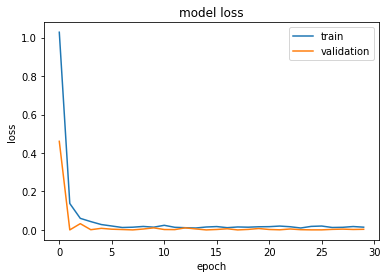

In [15]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [16]:
pred = model_lstm.predict(test_data_gen)

In [17]:
score, acc = model_lstm.evaluate(test_data_gen) #test

1/1 [==============================] - 0s 48ms/step - loss: 0.0129 - mse: 0.0129


In [18]:
test_data_gen[0]

(array([[[8.74508977e-01, 8.46216023e-01, 8.54779005e-01, 2.90011000e+05,
          8.53320003e-01, 1.48283467e-01],
         [1.01842594e+00, 9.71315980e-01, 9.74134028e-01, 3.71633000e+05,
          1.01481199e+00, 1.31502325e-01],
         [1.03011203e+00, 9.99375999e-01, 1.00855601e+00, 7.81560000e+05,
          1.00295198e+00, 1.53586280e-01],
         [8.61506999e-01, 8.36389005e-01, 8.52524996e-01, 2.11458000e+05,
          8.43836010e-01, 1.28670540e-01],
         [1.02025104e+00, 9.94093001e-01, 1.00297499e+00, 5.65050000e+05,
          9.99426007e-01, 1.14973180e-01]],
 
        [[1.01842594e+00, 9.71315980e-01, 9.74134028e-01, 3.71633000e+05,
          1.01481199e+00, 1.31502325e-01],
         [1.03011203e+00, 9.99375999e-01, 1.00855601e+00, 7.81560000e+05,
          1.00295198e+00, 1.53586280e-01],
         [8.61506999e-01, 8.36389005e-01, 8.52524996e-01, 2.11458000e+05,
          8.43836010e-01, 1.28670540e-01],
         [1.02025104e+00, 9.94093001e-01, 1.00297499e+00, 5.6

In [19]:
pred

array([[0.9513867],
       [0.9513867],
       [0.9513867]], dtype=float32)

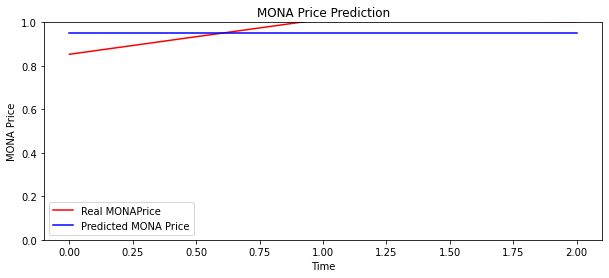

In [20]:
# Visualising the results
plt.figure(figsize=(10,4))
plt.plot(y_test[0:y_test.shape[0]-5], color = 'red', label = 'Real MONAPrice')
plt.plot(pred, color = 'blue', label = 'Predicted MONA Price')
plt.title('MONA Price Prediction')
plt.xlabel('Time')
plt.ylabel('MONA Price')
plt.ylim(0,1)
plt.legend()
plt.show()

In [21]:
# on cmd promt, you should use the function below to kill the tensorboard 
#taskkill /im tensorboard.exe /f
#del /q %TMP%\.tensorboard-info\*#

In [22]:
!kill 2592

'kill' is not recognized as an internal or external command,
operable program or batch file.


In [23]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 2592), started 1 day, 6:28:29 ago. (Use '!kill 2592' to kill it.)